- Introduction and About Yelp  (talk about the dataset and pertinent class labels)
- What is Sentiment Analysis in the Context of AI and NLP?  e.g. text classification  
- Framing the Problem Statement  
> What is the main objective and what are we trying to achive?  It might be best to **not** to only state predict whether review is positive, negative, or neutral but something more insightful/meaningful.  Keep in mind that sentiment analysis is nothing new and there are a number of implementations.       
- Data Analysis, Cleaning, and Transformation    
- Exploration and Visualization e.g. provide a bit of insight into the dataset.        
- Addressing Data imbalance (or class weights)    
- NLP: Word Tokenization, Sequences, and Embedding  
- RNN/LSTM(Bidirectional)/GRU  
> Overview of the RNN architecture.  Why a type of RNN, LSTM, applies to sentiment analysis.  Describe the archicture.  
- Transfer Learning  
> Can we have done Transfer Learning with pre-built models?  Does augmenting with Transfer Learning make any difference?
- SaS  
- Optimization Techniques  
- Addressing Over-Fitting  
- Predictions and Generating Text e.g. Auto-Completion  
> Does a model perform just as well on other context or domains?
- Evaluating Performance (Confusion Matrix)   
- Productionizing the Trained Model via API in AWS    
- Conclusion
> Provide the intuition behind the result. Why the model performed the way it did and what accounted for the performance.

<img src="cnn.png" alt="cnn key points" />

https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc

In [563]:
import datetime
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from datetime import timedelta
# 3rd-part library for managing imbalanced data.
from imblearn.under_sampling import RandomUnderSampler
from IPython.core.interactiveshell import InteractiveShell

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, MaxPooling1D, BatchNormalization, Conv1D, GRU, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [2]:

%matplotlib inline

# Set dataframe options to keep long data in columns from being truncated with ellipsis (...)
pd.set_option('max_colwidth', None)

# Set dataframe options to force display max columns
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 90)

InteractiveShell.ast_node_interactivity = "all"

random_state = 42


# Check if using a GPU
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.config.list_physical_devices('GPU') else '\t\u2022 GPU device not found. Running on CPU')


Using:
	• TensorFlow version: 2.1.0
	• tf.keras version: 2.2.4-tf
	• Running on GPU


In [507]:

def create_dataframe(file_path):
    '''
    Create a pandas dataframe from a JSON file indicated by the parameter file_path
    '''
    data = []
    with open(file_path, encoding="utf8") as f:
        for jsonObj in f:
            data.append(json.loads(jsonObj))
    return pd.DataFrame(data)


def df_info(df):
    '''
    A helper function - similar in functionality with `df.info()` but includes combined features: df.columns, df.dtypes, 
    df.isnull(), df.info(), df.nunique()
    '''
    print('\nShape : {}'.format(df.shape))
    print('Number of duplicates : {}\n'.format(df.duplicated().sum()))

    print('{:^35} {:^12} {:^12} {:^8} {:>10}\n'.format('COLUMNS', 'DATA TYPE', 'HAS NULL', 'COUNTS', '# UNIQUE'))
    for i, v in enumerate(df.columns):
        col = df[v]
        dtype = type(col.iloc[0]).__name__
        
        if dtype=='dict':
            keys = set([item for val in col.values if val is not None for item in list(val.keys())])
            col_nunique = len(keys)
        else:
            col_nunique = col.nunique()
        
        print(' {:>2}.  {:<30} {:<12} {:^10} {:>8} {:>10}'.format(i+1, v, dtype, \
                                                                  str(col.isnull().any()), col.count(), \
                                                                  col_nunique))    # col.nunique()

        
def pretty_print_review_and_label(X_df, y_df, samples=3):
    ix=X_df.sample(samples).index
    return pd.concat([y_df.iloc[ix], X_df.iloc[ix].text], axis=1)


def plot(history_data):
    '''
    Plot history data
    '''
    training_accuracy = history_data.history['accuracy']
    validation_accuracy = history_data.history['val_accuracy']

    training_loss = history_data.history['loss']
    validation_loss = history_data.history['val_loss']

    epochs_range=range(len(training_accuracy))

    fig = plt.figure(figsize=(10, 3.5), constrained_layout=True)
    gs = fig.add_gridspec(1, 6)
    fig_ax1 = fig.add_subplot(gs[0,:-3])
    fig_ax2 = fig.add_subplot(gs[0,3:])
    
    fig_ax1.plot(epochs_range, training_accuracy, label='Training Accuracy')
    fig_ax1.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    fig_ax1.legend(loc='lower right')
    fig_ax1.set_title('Training and Validation Accuracy')

    fig_ax2.plot(epochs_range, training_loss, label='Training Loss')
    fig_ax2.plot(epochs_range, validation_loss, label='Validation Loss')
    fig_ax2.legend(loc='upper right')
    fig_ax2.set_title('Training and Validation Loss')


Load the JSON dataset and persist as a CSV file.
> **Warning:** This process will take some to complete.

In [4]:

review_json = '../yelp_dataset/yelp_academic_dataset_review.json'
reviews_df = create_dataframe(review_json)
df_info(reviews_df)



Shape : (8021122, 9)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  review_id                      str            False     8021122    8021122
  2.  user_id                        str            False     8021122    1968703
  3.  business_id                    str            False     8021122     209393
  4.  stars                          float64        False     8021122          5
  5.  useful                         int64          False     8021122        266
  6.  funny                          int64          False     8021122        209
  7.  cool                           int64          False     8021122        200
  8.  text                           str            False     8021122    7999488
  9.  date                           str            False     8021122    7853102


Filter the dataframe to the features that are only needed.

In [5]:
reviews_dataset = reviews_df.drop(['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'], axis=1)

***
Reviews are from different type of establishments. Check to see if this can be filtered down to only dine/drink type of establishments where our sentiment analysis will focus on.

In [6]:
business_json = '../yelp_dataset/yelp_academic_dataset_business.json'
business_df = create_dataframe(business_json)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


The `categories` feature will be used to filter businesses to dine/drink.

In [7]:
# Business criteria: Restaurants, Bars, Pub, or wherever there's Food
eat_drink_business_df = business_df.query('not categories.isnull() and \
                  (categories.str.contains("Food") or categories.str.contains("Restaurants") \
                   or categories.str.contains("Bars") or categories.str.contains("Pub"))', 
                  engine='python')

eat_drink_business_df[['name', 'categories']].sample(5)

,name,categories
124386,La Tortilleria,"Mexican, Restaurants"
175538,Wendy's,"Fast Food, Restaurants, Burgers"
26617,America Latina,"Breakfast & Brunch, Mexican, Restaurants, American (Traditional)"
46709,FruiteaO,"Restaurants, Food, Desserts, Taiwanese, Tea Rooms, Juice Bars & Smoothies"
85194,Enso Tea Bar,"Acai Bowls, Food, Bubble Tea, Juice Bars & Smoothies"


Now that the dataset is filtered down to the type of establishments we need, the `is_open` feature can be used to only capture establishments that are still in business.

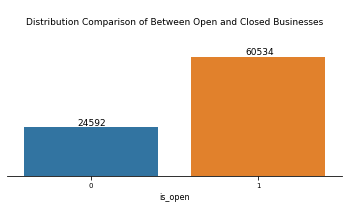

In [8]:
results = eat_drink_business_df.is_open
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 'axes.labelsize' : 8, 
          'xtick.labelsize' : 7, 'axes.titlesize':9}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=False, figsize=(6, 2.3))
ax = fig.gca()
ax.set_title('\nDistribution Comparison of Between Open and Closed Businesses\n\n')
p = sns.countplot(x=results, ax=ax)
ax.yaxis.set_visible(False)
counts=pd.Series(results).value_counts().sort_values(ascending=True)
for i, count in enumerate(counts):
    ax.text(i-.08, count+1000, '{}'.format(count), fontsize=9)

matplotlib.rcParams.update(matplotlib.rcParamsDefault);

> `24.5`k have gone out of business.

In [9]:
establishments_still_in_business = eat_drink_business_df.query('is_open == 1').business_id

reviews_dataset_open = reviews_dataset.query('business_id in @establishments_still_in_business')
df_info(reviews_dataset_open)



Shape : (4733942, 3)
Number of duplicates : 9393

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4733942      60534
  2.  stars                          float64        False     4733942          5
  3.  text                           str            False     4733942    4722100


> Dataset is reduced to 4.7 million and comprises only of establishments that are still in business.

There is no need for `business_id` at this point and can be dropped.

In [10]:
reviews_dataset_2features = reviews_dataset_open.drop(['business_id'], axis=1, inplace=False)

Review the distribution of the `stars` feature.

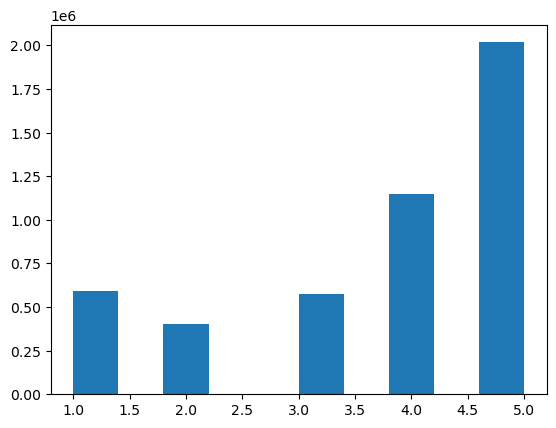

In [11]:
plt.hist(reviews_dataset_2features.stars);

Patrons rate establishments from 1 through 5 with 5 being the highest.  The `stars` value will be able to provide the appropriate label to the sentiments.  
However in lieu of the star ratings, this can be collated into: `negative`, `neutral`, `positive`.  
Reviews with 1 and 2 will fall into the negative, 3 into neutral, 4 and 5 into positive.

In [12]:
category_labels = [0, 1, 2]
cut_bins = [0, 2, 3, 5]
reviews_dataset_2features['sentiment'] = pd.cut(reviews_dataset_2features['stars'], bins=cut_bins, labels=category_labels)

Review the changes in the dataset; should now see the new column `sentiment`.

In [13]:
reviews_dataset_2features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4733942 entries, 2 to 8021121
Data columns (total 3 columns):
 #   Column     Dtype   
---  ------     -----   
 0   stars      float64 
 1   text       object  
 2   sentiment  category
dtypes: category(1), float64(1), object(1)
memory usage: 112.9+ MB


**Test the changes**.  All three queries should **not** return any values.

In [14]:
reviews_dataset_2features.query('stars == 3 and (sentiment == 2 or sentiment == 0)')
reviews_dataset_2features.query('stars < 3 and (sentiment == 1 or sentiment == 2)')
reviews_dataset_2features.query('stars > 3 and (sentiment == 0 or sentiment == 1)')

,stars,text,sentiment


,stars,text,sentiment


,stars,text,sentiment


Now that the `sentiment` feature has been created, there is no need for the `stars` feature.

In [15]:
reviews_dataset_2features.drop(['stars'], inplace=True, axis=1)

Persist the stripped-down dataset to make it more manageable and resource-utilization-friendly.

In [16]:
# Save the data to a new CSV file
reviews_dataset_2features.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)

Re-load the dataset as `reviews_sentiments`.

In [17]:
reviews_sentiments = pd.read_csv('../yelp_dataset/reviews_dataset.csv')
df_info(reviews_sentiments)


Shape : (4733942, 2)
Number of duplicates : 11386

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str             True     4733941    4722099
  2.  sentiment                      int64          False     4733942          3


> Initially the dataset did not have any NA values but after re-loading, it now appears we do.  This is because 'N/A' was interpreted as string during JSON conversion but is now recognized by `pandas` as a `NA` value after reloading the dataset.

Since NA values in text does not provide any meaningful data, it is pointless to keep this hence rows with NA is dropped.

In [18]:
reviews_sentiments.dropna(inplace=True)

Duplicates now appear in the dataset and needs to be investigated.

In [19]:
reviews_sentiments[1000:10000][reviews_sentiments[1000:10000].duplicated(subset=['text'], keep=False)]

,text,sentiment
7505,"Some cravings you just can't ignore! Today was our first time visiting Popcorn Heaven in Ballantyne. The smells alone are worth the trip! We were immediately greeted by the sales clerk who was helping another customer. (Call me old fashioned, but I like to be acknowledged. Her smile made us feel very welcomed!) Then Daniel the owner welcomed us and explained the menu, purchase options & specials. This place has folks pouring in & they all knew what they wanted. While my husband and I were trying to make a decision on flavors, Daniel graciously offered samples. It was...heavenly! Deee-lish! Fresh! Popcorn Heaven also ships! Prices were great when compared to online companies. I love shopping local & Popcorn Heaven will definitely be keeping my business! Oh, one last thought- Daniel said they make nice gift baskets for Valentines day. Seriously friends, give Popcorn Heaven a try!",2
9082,"Some cravings you just can't ignore! Today was our first time visiting Popcorn Heaven in Ballantyne. The smells alone are worth the trip! We were immediately greeted by the sales clerk who was helping another customer. (Call me old fashioned, but I like to be acknowledged. Her smile made us feel very welcomed!) Then Daniel the owner welcomed us and explained the menu, purchase options & specials. This place has folks pouring in & they all knew what they wanted. While my husband and I were trying to make a decision on flavors, Daniel graciously offered samples. It was...heavenly! Deee-lish! Fresh! Popcorn Heaven also ships! Prices were great when compared to online companies. I love shopping local & Popcorn Heaven will definitely be keeping my business! Oh, one last thought- Daniel said they make nice gift baskets for Valentines day. Seriously friends, give Popcorn Heaven a try!",2


> Selecting a subset/range of rows from the dataset, confirms that there are indeed duplicates.  It seems that after converting the JSON object into a dataframe, the `duplicated` function does not seem to work as expected.

Duplicates have no value and is a waste in resource so these need to be dropped.

In [20]:
reviews_sentiments.drop_duplicates(inplace=True)

Persist the dataset and reload.

In [21]:
# persist
reviews_sentiments.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)

In [22]:
# reload
reviews_sentiments = pd.read_csv('../yelp_dataset/reviews_dataset.csv')
df_info(reviews_sentiments)


Shape : (4722555, 2)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str            False     4722555    4722099
  2.  sentiment                      int64          False     4722555          3


> Dataset looks much cleaner now.

Divide the dataset into features and labels.

In [23]:
X = reviews_sentiments[['text']]
y = reviews_sentiments['sentiment']

The sentiment serves as a label to help in the process of training the model in the classification of reviews.
To effectively train the model with the dataset, we need to ensure the data has a balanced number of classifications.

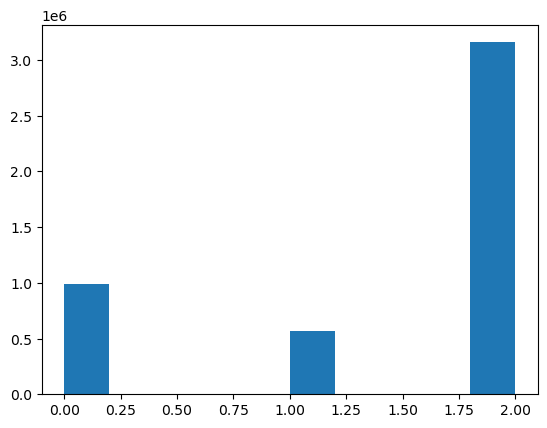

In [24]:
plt.hist(y);

> There is an imbalance in the dataset where there are significantly more `positive` rating than the other two sentiments.

To avoid bias where model is trained more on the positive labels, dataset need to be balanced.  A third-party library, `imb-learn` is used to under sample the dataset and balance out to the smallest denominator.

In [25]:

# RandomUnderSampler is used from the imblearn using the sampling-strategy auto
rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)

# The result is a resampled dataset of X and y
X_res, y_res = rus.fit_resample(X, y)


Review the newly-balanced dataset.

In [26]:
X_res.shape[0]/reviews_df.shape[0]

0.21371224624185992

In [27]:
# sanity check, X and y should be equal in number of instances
np.shape(X_res), np.shape(y_res)

((1714212, 1), (1714212,))

> The balanced dataset has been reduced to 21.4% of its original size but with 1.71 million, it is still a substantial amount that can be used to train and test the model.

Review the distribution of the sentiments from the newly-balanced dataset.

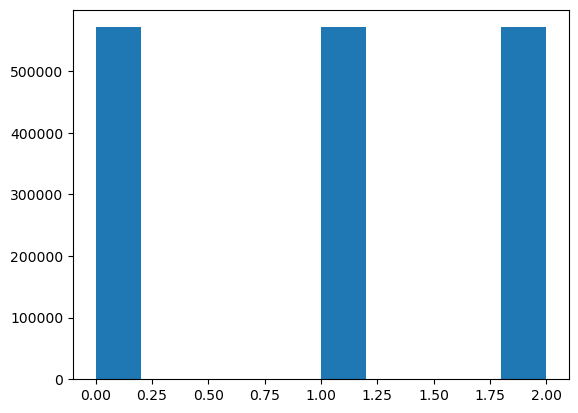

In [28]:
plt.hist(y_res);

> We now have a more balanced dataset across the different sentiments.

**Alternative Option :**  

Assign class weights during the model fit:

`model.fit(..., class_weight={0:1, 1:1, 2 / total nbr rows}`

> Key here is that more weight should be added to the class that has a lesser number of instances.

Split data into train and test.

In [29]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X_res.values, y_res.values, test_size=0.3)

Get the most number of words in all the reviews from the training dataset.

In [30]:
maxlen = 0
for x in X_train:
    review = x[0]
    if len(review.split()) > maxlen:
        maxlen = len(review.split())

print(maxlen)

1022


> This is the most number of words from one of the reviews.

Get the vocubulary size based on the unique words from the training dataset.

In [368]:
vocubulary = []
ctr=0

for x in X_train:
    unique_words = set(x[0].split())    # for each review, get the unique words
    vocubulary.extend(list(unique_words))    # add to the vocubulary list; duplicate words possible from one review to another

    ctr+=1
    if ctr % 100000 == 0:    
        vocubulary = list(set(vocubulary))    # every nth cycle, ensure uniqueness of the vocubulary

vocubulary = list(set(vocubulary))   # ensure uniqueness one more time
num_words = len(vocubulary)    # this is the size of the vocubulary used by patrons in the reviews dataset
num_words

1322808

How many words should be relevant in a review?  Having a large number of words may potentially add noise and weaken the predicting performance of the model.  Likewise, having a small number of words may not make our model as strong as it is limited to small number of words.  

`num_words` will have to be a hyper-parameter and will determine how many or few to make an effective model. 

In [32]:
tokenizer = Tokenizer(num_words=num_words, oov_token='<oov>')
tokenizer.fit_on_texts(X_train.reshape(X_train.shape[0],).tolist())
word_index = tokenizer.word_index
len(word_index)

279360

In [33]:
sequences = tokenizer.texts_to_sequences(X_train.reshape(X_train.shape[0],).tolist())

Pre-padding(`pre`) or post-padding(`post`)?  What is important for `LSTM`?  
> This can be a hyper-parameter and whichever will make a better performing model will be the selected configuration.

In [34]:
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post')
padded_sequences.shape

(1199948, 1022)

> The `maxlen` parameter in the `pad_sequences` function can be another hyper-parameter.  
> Need to evaluate what makes sense as a length and how it affects the predicting performance of the model.  **Note:** Words will be truncated if the sentence exceeds these number of words.  
> The `truncating` parameter of the `pad_sequences` function should also be considered as a hyper-parameter and whether or not a `pre` or `post` truncating value makes the model stronger.

In [35]:
test_sequences = tokenizer.texts_to_sequences(X_test.reshape(X_test.shape[0],).tolist())
test_padded_sequences = pad_sequences(test_sequences, maxlen=maxlen, padding='post')
test_padded_sequences.shape

(514264, 1022)

Define hyper-parameters for the neural network.

In [36]:
embedding_dimensions = 16
epochs = 10

Build a fully-connected deep-neural network.

In [37]:
tf.keras.backend.clear_session()  

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dimensions, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1022, 16)          21164928  
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                204       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 39        
Total params: 21,165,171
Trainable params: 21,165,171
Non-trainable params: 0
_________________________________________________________________


Train the model, collecting the train and validation metrics.

In [38]:
history = model.fit(padded_sequences, y_train, epochs=epochs, validation_data=(test_padded_sequences, y_test))

Train on 1199948 samples, validate on 514264 samples
Epoch 1/10
1199948/1199948 [==============================] - 6704s 6ms/sample - loss: 0.5578 - accuracy: 0.7606 - val_loss: 0.5366 - val_accuracy: 0.7743
Epoch 2/10
1199948/1199948 [==============================] - 6027s 5ms/sample - loss: 0.5217 - accuracy: 0.7786 - val_loss: 0.5362 - val_accuracy: 0.7731
Epoch 3/10
1199948/1199948 [==============================] - 6042s 5ms/sample - loss: 0.5106 - accuracy: 0.7844 - val_loss: 0.5379 - val_accuracy: 0.7669
Epoch 4/10
1199948/1199948 [==============================] - 6098s 5ms/sample - loss: 0.5032 - accuracy: 0.7880 - val_loss: 0.5636 - val_accuracy: 0.7605
Epoch 5/10
1199948/1199948 [==============================] - 5959s 5ms/sample - loss: 0.4969 - accuracy: 0.7909 - val_loss: 0.5212 - val_accuracy: 0.7815
Epoch 6/10
1199948/1199948 [==============================] - 5893s 5ms/sample - loss: 0.4921 - accuracy: 0.7932 - val_loss: 0.5265 - val_accuracy: 0.7777
Epoch 7/10
119994

> **Note :** This ran for 16.5 hours.
> #### Clearly the parameters are not ideal more so as a starting point.

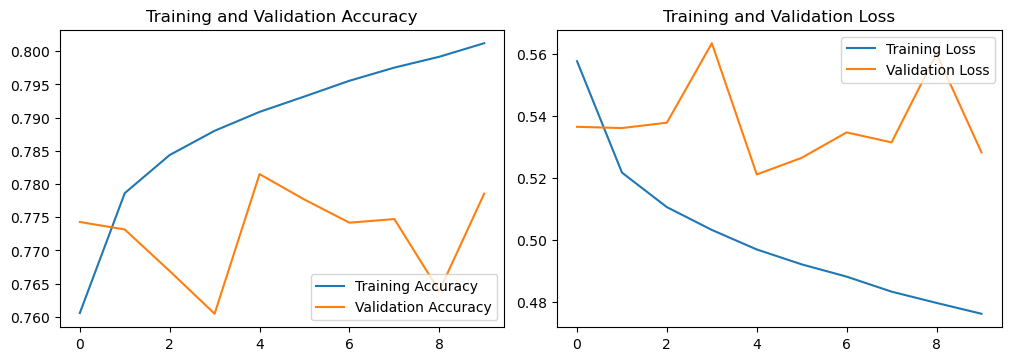

In [62]:
plot(history)

Scale down the size of the tokenizer and max length.

In [100]:
review_lengths = []
for x in X_train:
    review = x[0]
    review_lengths.append(len(review.split()))

In [288]:
# plot lenghts of reviews
x=pd.Series(np.array(review_lengths))

# IQR
IQR = x.describe()['75%'] - x.describe()['25%']

# IQR multiplier to set the whisker/boundary for outliers (default is 1.5)
IQR_multiplier = 1.5

# Defining threshold as the 3rd Quartile + (IQR * IQR_multiplier)
outlier_threshold = math.floor(x.describe()['75%'] + (IQR*IQR_multiplier))

print('\nStatistically accepted boundary for outliers : {}\n'.format(outlier_threshold))


Statistically accepted boundary for outliers : 300



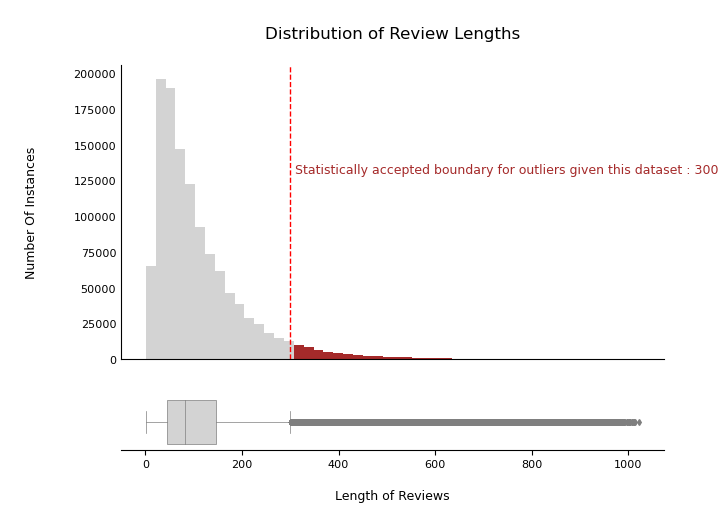

In [120]:
params = {'axes.titlesize':'9', 'xtick.labelsize':'8', 'ytick.labelsize':'8', 'axes.spines.top':False,
          'axes.spines.right': False}
matplotlib.rcParams.update(params)
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .15)})
ax_hist.set_title('\nDistribution of Review Lengths\n', fontdict={'fontsize': 12});
ax_hist.set_ylabel('\nNumber Of Instances\n\n', fontdict={'fontsize': 9})
ax_hist.tick_params(bottom="off", length=0)
ax_hist.axvline(x=outlier_threshold, c='r', linestyle='--', linewidth=1)
text = ' Statistically accepted boundary for outliers given this dataset : {}\n'
ax_hist.annotate(text.format(int(outlier_threshold)), (outlier_threshold+1, x.count()/10), fontsize=9, color='brown')
ax_box.spines['left'].set_visible(False)
ax_box.yaxis.set_visible(False)

res = x.hist(figsize=(7, 5), color='lightgray', grid=False, ax=ax_hist, bins=50)

for idx, rec in enumerate(res.patches):
    if rec.xy[0] > outlier_threshold-1:
        res.patches[idx].set_fc('brown')  
bx = sns.boxplot(x, ax=ax_box, fliersize=3, color='lightgray', linewidth=.5, whis=IQR_multiplier)
bx
ax_box.set_xlabel('\nLength of Reviews', fontdict={'fontsize': 9})
#plt.tight_layout();
matplotlib.rcParams.update(matplotlib.rcParamsDefault);

> It is impractical to use the full max length due to the length of training time.  
> Using the max length will even make the training longer during optimization.  
> There is a need to strike a balance between acceptable max length and training time.  
> Most reviews have a max length of 300 and less. Reviews above 300 are outliers.  

In [141]:
tokenizer_2 = Tokenizer(num_words=num_words//1000, oov_token='<oov>')
tokenizer_2.fit_on_texts(X_train.reshape(X_train.shape[0],).tolist())
word_index_2 = tokenizer_2.word_index
len(word_index_2)

279360

In [142]:
maxlen_2 = 300

sequences_2 = tokenizer_2.texts_to_sequences(X_train.reshape(X_train.shape[0],).tolist())
padded_sequences_2 = pad_sequences(sequences_2, maxlen=maxlen_2, padding='post')
padded_sequences_2.shape

test_sequences_2 = tokenizer_2.texts_to_sequences(X_test.reshape(X_test.shape[0],).tolist())
test_padded_sequences_2 = pad_sequences(test_sequences_2, maxlen=maxlen_2, padding='pre')
test_padded_sequences_2.shape

(1199948, 300)

(514264, 300)

In [143]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words//1000, embedding_dimensions, input_length=maxlen_2),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_2.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), 
              metrics=['accuracy'])
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 16)           21152     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 12)                204       
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 39        
Total params: 21,395
Trainable params: 21,395
Non-trainable params: 0
_________________________________________________________________


In [144]:
start_time = time.time()
history_2 = model_2.fit(padded_sequences_2, y_train, epochs=100, 
                        validation_data=(test_padded_sequences_2, y_test))
elapsed_time = time.time() - start_time
print('Elapsed time : ', str(timedelta(seconds=elapsed_time)))

Train on 1199948 samples, validate on 514264 samples
Epoch 1/100
1199948/1199948 [==============================] - 252s 210us/sample - loss: 0.5770 - accuracy: 0.7498 - val_loss: 0.5562 - val_accuracy: 0.7606
Epoch 2/100
1199948/1199948 [==============================] - 274s 228us/sample - loss: 0.5639 - accuracy: 0.7557 - val_loss: 0.5580 - val_accuracy: 0.7596
Epoch 3/100
1199948/1199948 [==============================] - 226s 188us/sample - loss: 0.5612 - accuracy: 0.7567 - val_loss: 0.5845 - val_accuracy: 0.7450
Epoch 4/100
1199948/1199948 [==============================] - 225s 188us/sample - loss: 0.5601 - accuracy: 0.7571 - val_loss: 0.5547 - val_accuracy: 0.7598
Epoch 5/100
1199948/1199948 [==============================] - 223s 185us/sample - loss: 0.5600 - accuracy: 0.7571 - val_loss: 0.5642 - val_accuracy: 0.7561
Epoch 6/100
1199948/1199948 [==============================] - 224s 187us/sample - loss: 0.5592 - accuracy: 0.7576 - val_loss: 0.5566 - val_accuracy: 0.7598
Epoch

1199948/1199948 [==============================] - 229s 191us/sample - loss: 0.5579 - accuracy: 0.7582 - val_loss: 0.5548 - val_accuracy: 0.7586
Epoch 53/100
1199948/1199948 [==============================] - 233s 194us/sample - loss: 0.5581 - accuracy: 0.7577 - val_loss: 0.5563 - val_accuracy: 0.7605
Epoch 54/100
1199948/1199948 [==============================] - 234s 195us/sample - loss: 0.5574 - accuracy: 0.7585 - val_loss: 0.5530 - val_accuracy: 0.7604
Epoch 55/100
1199948/1199948 [==============================] - 233s 194us/sample - loss: 0.5576 - accuracy: 0.7582 - val_loss: 0.5752 - val_accuracy: 0.7496
Epoch 56/100
1199948/1199948 [==============================] - 238s 198us/sample - loss: 0.5577 - accuracy: 0.7583 - val_loss: 0.5631 - val_accuracy: 0.7570
Epoch 57/100
1199948/1199948 [==============================] - 235s 196us/sample - loss: 0.5574 - accuracy: 0.7589 - val_loss: 0.5588 - val_accuracy: 0.7573
Epoch 58/100
1199948/1199948 [==============================] - 2

Result with pre padding

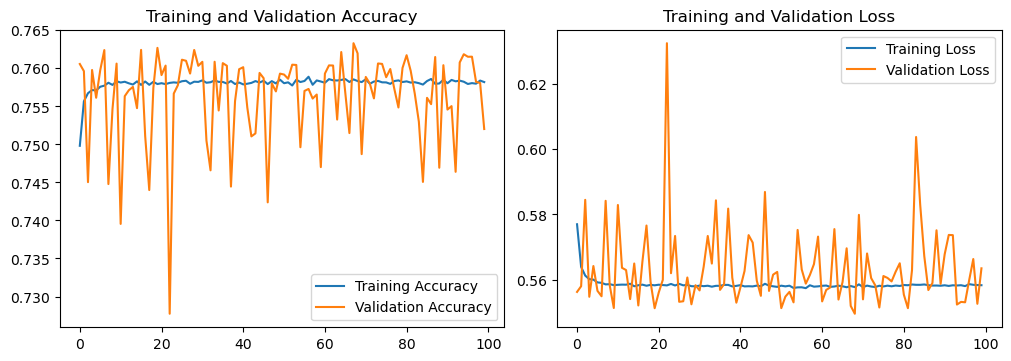

In [145]:
plot(history_2)

Result with post padding

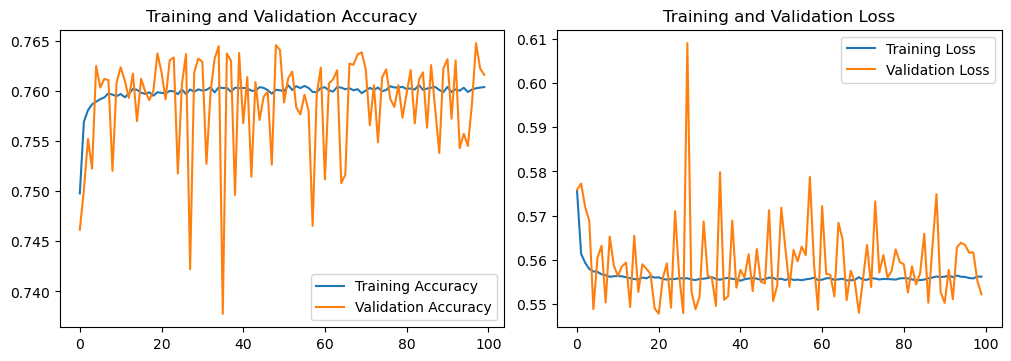

In [133]:
plot(history_2)

> Lowering max length speeds up training.  
> Reducing max length down to 30% of the largest review, training time is approximately 40% faster with 100 epochs compared to 10 epochs at 16.5 hours.  
> There is approximately 3-4% accuracy impact with the reduced max length.  This is difficult to gauge because at 10 epochs running for 16.5 hours, the final result cannot be reliably determined.  
> In an attempt to improve the performance, the pre and post padding were compared.  Pre and post padding has no effect on model performance.  


Model is not learning enough and confidence is unstable based on the validation shown on the graph.  
This may be because the model is unable to find the right correlation and/or there is noise on the data it is processing.  
There is a need to understand the vocubulary and word index.  

In [554]:

def rnn_stage_1(tensor, c_params):
    '''
    Helper method for building RNN stage 1
    '''
    x = tensor
    
    for params in c_params:
        x = LSTM(params['hidden_state_dim'], return_sequences=params['return_sequences'])(x)
        
        if 'batch_normalization' in params.keys():
            x = BatchNormalization()(x)
        
        if 'max_pooling' in params.keys():
            x = MaxPooling1D(params['max_pooling'])(x)
    
    return x

def rnn_stage_2(x, d_params, init_dropout, num_classes, output_activation):
    '''
    DNN helper method for building RNN stage 2
    '''
    #x = Flatten()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    if init_dropout:
        x = Dropout(init_dropout)(x)
    
    for params in d_params:
        x = Dense(units=params['units'], activation=params['activation'])(x)
        
        if 'dropout' in params.keys(): 
            x = Dropout(params['dropout'])(x)
    
    return Dense(num_classes, output_activation)(x)


def build_rnn(shape, word_index, embedding_dim, c_params, d_params, init_dropout, num_classes, output_activation):
    '''
    Build an RNN (stage 1 and 2)
    '''
    i = Input(shape=shape)
    x = tf.keras.layers.Embedding(word_index + 1, embedding_dim)(i)
    x = rnn_stage_1(x, c_params=c_params)
    x = rnn_stage_2(x, d_params, init_dropout, num_classes, output_activation)
    model = Model(i, x)
    return model


In [590]:
# Avoiding under-sampling... these are now bigger train/test data
# Takes a much longer time to train
#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3)

In [588]:
epochs_ = 2
num_words_ = num_words // 1000    # the higher the number the lesser nbr of words (focus on common?)
embedding_dimensions_ = 32
maxlen_ = 100
padding_ = "post"
truncating_ = "post"
learning_rate_ = 0.05

# Set up word tokens to get most common words
tokenizer_ = Tokenizer(num_words=num_words_, oov_token='<oov>')
tokenizer_.fit_on_texts(X_train.reshape(X_train.shape[0],).tolist())
word_index_ = tokenizer_.word_index
print('Vocubulary size : {}'.format(num_words_))
print('Unique tokens : {}'.format(len(word_index_)))

# leave last element without max_pooling
c_params = [
    {'hidden_state_dim':  32, 'return_sequences': True}
]

init_dropout=False

# Stage2 hyper-parameters
d_params = [
    {'units': 32, 'activation': 'relu'}
]

shape = (maxlen_,)
tf.keras.backend.clear_session()
M = build_rnn(shape, len(word_index_), embedding_dimensions_, c_params, d_params, init_dropout, 3, 'softmax')

class_weights = {0: round( 1 / (len(y[y==0])/len(y) ), 0), 
                 1: round( 1 / (len(y[y==1])/len(y) ), 0), 
                 2: round( 1 / (len(y[y==2])/len(y) ), 0)}

M.compile(loss='sparse_categorical_crossentropy', 
          optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_), 
          #optimizer=RMSprop(learning_rate=learning_rate_, momentum=.9),
          metrics=['accuracy'])
M.summary()


Vocubulary size : 1322
Unique tokens : 479308
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 32)           15337888  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 32)           8320      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 15,347,363
Trainable params: 15,347,363
Non-trainable params: 0
___

In [579]:
# Train
sequences_ = tokenizer_.texts_to_sequences(X_train.reshape(X_train.shape[0],).tolist())
padded_sequences_ = pad_sequences(sequences_, maxlen=maxlen_, padding=padding_, truncating=truncating_)
padded_sequences_.shape

# Test
test_sequences_ = tokenizer_.texts_to_sequences(X_test.reshape(X_test.shape[0],).tolist())
test_padded_sequences_ = pad_sequences(test_sequences_, maxlen=maxlen_, padding=padding_, truncating=truncating_)
test_padded_sequences_.shape

(3305788, 100)

(1416767, 100)

In [589]:
start_time = time.time()

#history_ = M.fit(padded_sequences_, y_train, epochs=epochs_, validation_data=(test_padded_sequences_, y_test))
history_ = M.fit(padded_sequences_, y_train, 
                 epochs = epochs_, 
                 validation_data = (test_padded_sequences_, y_test),
                 class_weight = class_weights)

elapsed_time = time.time() - start_time
print('Elapsed time : ', str(timedelta(seconds=elapsed_time)))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3305788 samples, validate on 1416767 samples
Epoch 1/2
1919712/3305788 [================>.............] - ETA: 1:18:23 - loss: 2.0269 - accuracy: 0.6442

KeyboardInterrupt: 

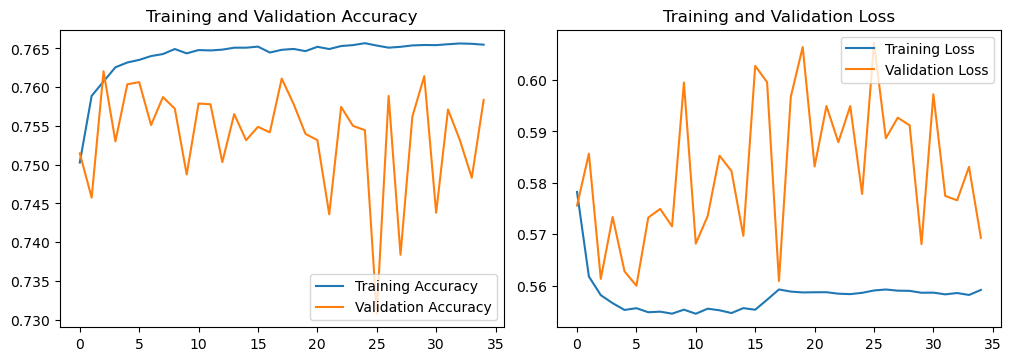

In [506]:
plot(history_)

In [517]:
pretty_print_review_and_label(pd.DataFrame(X_test, columns=['text']), pd.DataFrame(y_test), 3)

,0,text
481238,2,"Alright so this place wins. It wins the prize for the most expensive grocery Market in The Valley. If there is a higher priced one, I have not been there yet.\nAlthough, it has not stopped me from going here. \nEvery time I do ,I say why??\nYes, they have a lot of amazing ,pure ,and healthy foods. Yes, the store is clean and you can find anything you could ever want here as well.\nIf you are too tired to cook anything you can come here and get anything you want , cooked and ready to eat, or take it home and heat it up.\nLoads of fresh fruit and vegetables, as well as anything else your heart could desire. \nYou get .10cents off for each bag you bring in. \nThere is lots of parking in the lot. They are in the same parking lot as Trader Joe's which seems a little odd. But, that is major comp. there.\nIt certainly is worth a visit."
13258,1,"They don't make any smoothies fresh in house. A little disappointed about that. What they had bottles in the fridge was nice though. Their kombucha on tap is excellent. Overall, pretty nice juice and smoothie. It's just not made in house."
153330,2,Americana is absolutely our favorite date spot! This restaurant is in our neighborhood so that's a plus from the start. The food is creative and delicious! The chef is always willing to adjust menu items to suit your needs. The table service is amazing! They have an amazing bar as well.


In [442]:
num_words//100

13228

In [436]:
num_words_3 = num_words // 200
embedding_dimensions_3 = 32
maxlen_3 = 100

tokenizer_3 = Tokenizer(num_words=num_words_3, oov_token='<oov>')
tokenizer_3.fit_on_texts(X_train.reshape(X_train.shape[0],).tolist())
word_index_3 = tokenizer_3.word_index
len(word_index_3)

279360

In [437]:

sequences_3 = tokenizer_3.texts_to_sequences(X_train.reshape(X_train.shape[0],).tolist())
padded_sequences_3 = pad_sequences(sequences_3, maxlen=maxlen_3, padding='post')
padded_sequences_3.shape

test_sequences_3 = tokenizer_3.texts_to_sequences(X_test.reshape(X_test.shape[0],).tolist())
test_padded_sequences_3 = pad_sequences(test_sequences_3, maxlen=maxlen_3, padding='post')
test_padded_sequences_3.shape

(1199948, 100)

(514264, 100)

In [438]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words_3, embedding_dimensions_3, input_length=maxlen_3),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_3.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), 
              metrics=['accuracy'])
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           211648    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                396       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 39        
Total params: 212,083
Trainable params: 212,083
Non-trainable params: 0
_________________________________________________________________


In [439]:
start_time = time.time()
history_3 = model_3.fit(padded_sequences_3, y_train, epochs=1, 
                        validation_data=(test_padded_sequences_3, y_test))
elapsed_time = time.time() - start_time
print('Elapsed time : ', str(timedelta(seconds=elapsed_time)))

Train on 1199948 samples, validate on 514264 samples
1199948/1199948 [==============================] - 386s 322us/sample - loss: 0.5766 - accuracy: 0.7500 - val_loss: 0.5678 - val_accuracy: 0.7559
Elapsed time :  0:06:25.985136


Inputshape=(T, )) where T is the training data padded sequences length (not rows)  
Embedding with LSTM is TxD where T = tokenizer word index + 1 and D = number of dimensions  
LSTM(M, return_sequences=True)  where M is hyper-parameter indicating hidden-state dimensionality  
GlobalMaxPooling1D() because of parameter return_sequences=True  

